In [1]:
## import
import torch,torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn as nn

In [2]:
%cd /kaggle/working/
!mkdir VaeGan
%cd VaeGan
!mkdir data
!mkdir images

/kaggle/working
/kaggle/working/VaeGan


In [3]:
## 加载数据
img_size=64
batch_size=64
channels=1
dataset=torchvision.datasets.MNIST(
    'data/mnist',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ])
)
dataloader=torch.utils.data.DataLoader(dataset,batch_size=batch_size)
dataloader

100%|██████████| 9912422/9912422 [00:00<00:00, 186863847.89it/s]


Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 48786022.48it/s]

Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 37666407.40it/s]


Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8881365.39it/s]


Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



In [4]:
inputs,labels=next(iter(dataloader))

In [5]:
## 定义block
def encoder_block(in_c,out_c):
    layers=[
        nn.Conv2d(in_c,out_c,5,2,2,bias=False),
        nn.BatchNorm2d(out_c,0.9),
        nn.ReLU(True),
    ]
    return layers

def decoder_block(in_c,out_c):
    layers=[
        nn.ConvTranspose2d(in_c,out_c,5,2,2,1,bias=False),
        nn.BatchNorm2d(out_c,0.9),
        nn.ReLU(True),
    ]
    return layers
    

In [6]:
## 定义编码器

class Encoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.channels=channels
        self.z_dim=z_dim
        self.layers=[]
        self.img_size=img_size
        for i in range(3):
            if i==0:
                self.layers.extend(encoder_block(self.channels,64))
                self.channels=64
            else:
                self.layers.extend(encoder_block(self.channels,self.channels*2))
                self.channels*=2
        self.conv=nn.Sequential(*self.layers)
        self.img_size=self.img_size//8
        ## output:(batch,self.channels,img_size/8,img_size/8)
        self.fc=nn.Sequential(
            #nn.Flatten(),
            nn.Linear(self.channels*self.img_size*self.img_size,1024,bias=False),
            nn.BatchNorm1d(num_features=1024),
            nn.ReLU(True)    
        )
        self.output=nn.Sequential(nn.Linear(1024,self.z_dim*2))
        
     


    def forward(self, x):
        x=self.conv(x)
        x=x.view(len(x),-1)
        #print(x.shape)
        x=self.fc(x)
        x=self.output(x)
        mu, log_var = x.split(self.z_dim, dim=1)
        return mu,log_var
    
encoder=Encoder(128)
mu,log_var=encoder(inputs)

In [7]:
## 定义解码器
class Reshape(nn.Module):
    def __init__(self, args):
        super(Reshape, self).__init__()
        self.shape = args
    def forward(self, x):
        return x.view(self.shape)
    
class Decoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.channels=256
        self.img_size=img_size//8
        self.fc=nn.Sequential(
            nn.Linear(z_dim, out_features=self.channels*self.img_size*self.img_size, bias=False),
            nn.BatchNorm1d(num_features=self.channels*self.img_size*self.img_size,momentum=0.9),
            nn.ReLU(True),
            Reshape((-1,self.channels,self.img_size,self.img_size)),
        )
        self.conv=nn.Sequential(
            *decoder_block(self.channels,self.channels),
            *decoder_block(self.channels,self.channels//2),
            *decoder_block(self.channels//2,self.channels//8),
            nn.Conv2d(self.channels//8,channels,5,1,2),
            nn.Tanh()
        )
        

    def forward(self, x):
        x=self.fc(x)
        return self.conv(x)

decoder=Decoder(128)
z=torch.randn_like(mu)
decoder(z).shape

torch.Size([64, 1, 64, 64])

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.channels=channels
        #self.img_size
        self.Reco=nn.Sequential(
            nn.Conv2d(self.channels,32,5,1,2),
            nn.ReLU(),
            *encoder_block(32,128),
            *encoder_block(128,256),
            nn.Conv2d(256,256,5,2,2,bias=False),
        )
        self.img_size=img_size//8
        self.fc=nn.Sequential(
            nn.BatchNorm2d(256,0.9),
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(256*self.img_size*self.img_size,512,bias=False),
            nn.BatchNorm1d(512,0.9),
            nn.ReLU(True),
            nn.Linear(512,1),
            nn.Sigmoid()
        )
    def forward(self, ten_orig, ten_predicted, ten_sampled,mode='rec'):
        x=torch.cat([ ten_orig, ten_predicted, ten_sampled],dim=0)
        if mode =='rec':
            return self.Reco(x)
        else:
            x=self.Reco(x)
            x=self.fc(x)
            return x
d=Discriminator()
d(inputs,inputs,inputs).shape

torch.Size([192, 256, 8, 8])

In [10]:
## 构建VAE-GAN
class VaeGan(nn.Module):
    def __init__(self,z_dim):
        super().__init__()
        self.z_dim=z_dim
        self.encoder=Encoder(self.z_dim)
        self.decoder=Decoder(self.z_dim)
        self.discriminator=Discriminator()
        
        self.init_weight()
    
    def init_weight(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
                if hasattr(m, "weight") and m.weight is not None and m.weight.requires_grad:
                    #init as original implementation
                    scale = 1.0/np.sqrt(np.prod(m.weight.shape[1:]))
                    scale /=np.sqrt(3)
                    #nn.init.xavier_normal(m.weight,1)
                    #nn.init.constant(m.weight,0.005)
                    nn.init.uniform_(m.weight,-scale,scale)
                if hasattr(m, "bias") and m.bias is not None and m.bias.requires_grad:
                    nn.init.constant_(m.bias, 0.0)
    
    #从均值和标准差中采样
    def resample(self,mu,log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + std * eps
        return z
    
    def forward(self,x,z_p):
        mu,log_var=self.encoder(x)
        z=self.resample(mu,log_var)
        x_tilde=self.decoder(z)
        
        #z_p=torch.randn(len(x), z_dim)
        x_p=self.decoder(z_p)
        
        disc_layer = self.discriminator(x, x_tilde, x_p, "REC")  # discriminator for reconstruction
        disc_class = self.discriminator(x, x_tilde, x_p, "GAN")
        
        return x_tilde, disc_class, disc_layer,mu,log_var
vae_gan=VaeGan(128)
vae_gan(inputs,z)[0].shape

torch.Size([64, 1, 64, 64])

In [11]:
## 损失函数
def loss(x, x_tilde, disc_layer_original, disc_layer_predicted, disc_layer_sampled, disc_class_original, disc_class_predicted, disc_class_sampled, mu, log_var):
    # reconstruction error, not used for the loss but useful to evaluate quality
    nle = 0.5*(x.view(len(x), -1) - x_tilde.view(len(x_tilde), -1)) ** 2
    
    # kl-divergence
    kl = -0.5 * torch.sum(-log_var.exp() - torch.pow(mu,2) + log_var+ 1, 1)

    # mse between intermediate layers
    mse = torch.sum(0.5*(disc_layer_original - disc_layer_predicted) ** 2, 1)

    # bce for decoder and discriminator for original and reconstructed
    bce_dis_original = -torch.log(disc_class_original + 1e-3)
    bce_dis_predicted = -torch.log(1 - disc_class_predicted + 1e-3)
    bce_dis_sampled = -torch.log(1 - disc_class_sampled + 1e-3)

    return nle, kl, mse, bce_dis_original, bce_dis_predicted, bce_dis_sampled
def encoder_loss( disc_layer_original, disc_layer_predicted, mu, log_var):
    # kl-divergence
    kl = -0.5 * torch.sum(-log_var.exp() - torch.pow(mu,2) + log_var+ 1, 1)

    # mse between intermediate layers
    mse = torch.sum(0.5*(disc_layer_original - disc_layer_predicted) ** 2, 1)
    return kl,mse
def dis_loss(disc_class_original, disc_class_predicted, disc_class_sampled):
    bce_dis_original = -torch.log(disc_class_original + 1e-3)
    bce_dis_predicted = -torch.log(1 - disc_class_predicted + 1e-3)
    bce_dis_sampled = -torch.log(1 - disc_class_sampled + 1e-3)
    return bce_dis_original,bce_dis_predicted, bce_dis_sampled
#def decoder_loss()

In [12]:
# 定义超参数
z_dim=128
lr=0.0002
decay_lr=0.75
# 判断是否有可用GPU
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# 打印设备
print(device)

cuda:0


In [16]:
from torch.optim import RMSprop,Adam,SGD
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR
net = VaeGan(z_dim).to(device)
optimizer_encoder = RMSprop(params=net.encoder.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
lr_encoder = ExponentialLR(optimizer_encoder, gamma=decay_lr)

#optimizer_decoder = Adam(params=net.decoder.parameters(),lr = lr,betas=(0.9,0.999))
#lr_decoder = MultiStepLR(optimizer_decoder,milestones=[2],gamma=1)
optimizer_decoder = RMSprop(params=net.decoder.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
lr_decoder = ExponentialLR(optimizer_decoder, gamma=decay_lr)

#optimizer_discriminator = Adam(params=net.discriminator.parameters(),lr = lr,betas=(0.9,0.999))
#lr_discriminator = MultiStepLR(optimizer_discriminator,milestones=[2],gamma=1)
optimizer_discriminator = RMSprop(params=net.discriminator.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
lr_discriminator = ExponentialLR(optimizer_discriminator, gamma=decay_lr)

In [14]:
epochs=10
margin = 0.35
equilibrium = 0.68
def show(imgs):
    plt.figure(figsize=(6,6))
    imgs=torchvision.utils.make_grid(imgs,nrow=10,padding=2)     
    imgs=imgs.detach().cpu().numpy().transpose(1, 2, 0)
    plt.imshow(imgs*0.5+0.5)
    plt.show()
def plot(batch_done,loss_list,color_list):
    plt.figure(figsize=(6,6))
    for y,c in zip(loss_list,color_list):
        plt.plot(range(batch_done+1),y,color=c)
    plt.show()
                 

### 训崩了
### 待解决

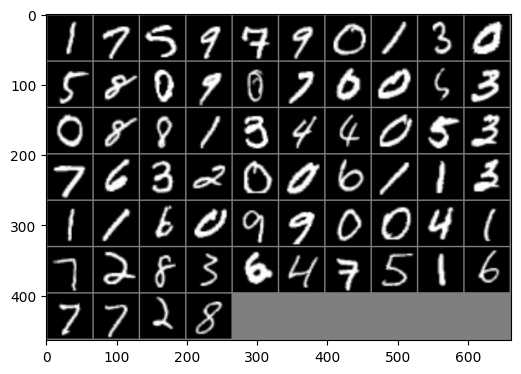

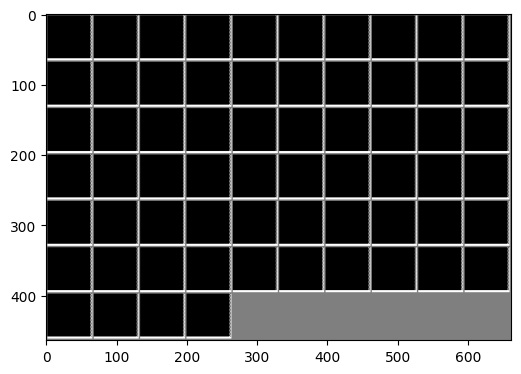

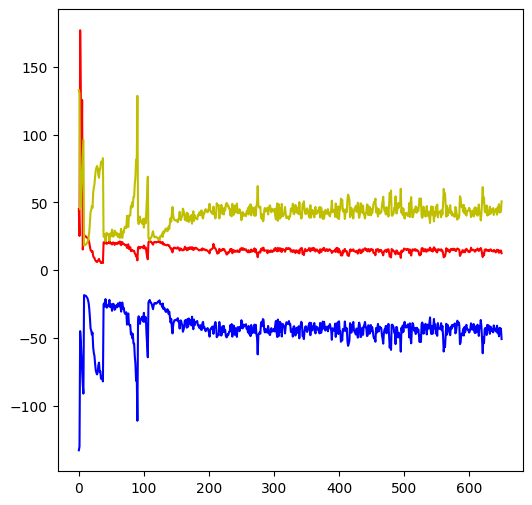

[00] encoder loss: 8.51467 | decoder loss: -65.52640 | discriminator loss: 65.52647
[00] encoder loss: 8.90742 | decoder loss: -61.26823 | discriminator loss: 61.26830
[00] encoder loss: 9.36656 | decoder loss: -63.50413 | discriminator loss: 63.50420
[00] encoder loss: 14.35795 | decoder loss: -46.86369 | discriminator loss: 46.86375
[00] encoder loss: 14.89260 | decoder loss: -43.21892 | discriminator loss: 43.21898
[00] encoder loss: 16.05081 | decoder loss: -38.57559 | discriminator loss: 38.57564
[00] encoder loss: 15.68353 | decoder loss: -40.20937 | discriminator loss: 40.20943
[00] encoder loss: 14.87592 | decoder loss: -43.82184 | discriminator loss: 43.82190
[00] encoder loss: 15.54347 | decoder loss: -39.89327 | discriminator loss: 39.89333


KeyboardInterrupt: 

In [17]:
from IPython.display import clear_output
loss_encoder_list=[]
loss_decoder_list=[]
loss_dis_list=[]
for epoch in range(epochs):
    for batch,(imgs,labels) in enumerate(dataloader):
        batch_size=imgs.shape[0]
        imgs=imgs.to(device)
        z_p=torch.randn(batch_size, z_dim).to(device)
        
        x_tilde, disc_class, disc_layer,mu,log_var=net(imgs,z_p)

        disc_layer_original ,disc_layer_predicted,disc_layer_sampled=torch.split(disc_layer,batch_size)
        disc_class_original ,disc_class_predicted,disc_class_sampled=torch.split(disc_class,batch_size)

        nle, kl, mse, bce_dis_original, bce_dis_predicted, bce_dis_sampled =loss(imgs, x_tilde, \
                                                                       disc_layer_original, disc_layer_predicted, disc_layer_sampled, 
                                                                        disc_class_original, disc_class_predicted, disc_class_sampled,
                                                                       mu, log_var)
        loss_discriminator = torch.sum(bce_dis_original) + torch.sum(bce_dis_predicted) + torch.sum(bce_dis_sampled)
        net.zero_grad()
        loss_discriminator.backward()
        optimizer_discriminator.step()
        
        
        x_tilde, disc_class, disc_layer,mu,log_var=net(imgs,z_p)
        
        disc_layer_original ,disc_layer_predicted,disc_layer_sampled=torch.split(disc_layer,batch_size)
        disc_class_original ,disc_class_predicted,disc_class_sampled=torch.split(disc_class,batch_size)
        
        nle, kl, mse, bce_dis_original, bce_dis_predicted, bce_dis_sampled =loss(imgs, x_tilde, \
                                                                       disc_layer_original, disc_layer_predicted, disc_layer_sampled, 
                                                                        disc_class_original, disc_class_predicted, disc_class_sampled,
                                                                        mu, log_var)
      
        #kl,mse=encoder_loss( disc_layer_original, disc_layer_predicted, mu, log_var)
        loss_encoder = torch.sum(kl)+torch.sum(mse)#用判别器抽取的特征作为重建损失
        
        
        #print(torch.sum(mse),loss_discriminator)
        net.zero_grad()
        loss_encoder.backward()
        optimizer_encoder.step()
        
        
        x_tilde, disc_class, disc_layer,mu,log_var=net(imgs,z_p)

        disc_layer_original ,disc_layer_predicted,disc_layer_sampled=torch.split(disc_layer,batch_size)
        disc_class_original ,disc_class_predicted,disc_class_sampled=torch.split(disc_class,batch_size)

        nle, kl, mse, bce_dis_original, bce_dis_predicted, bce_dis_sampled =loss(imgs, x_tilde, \
                                                                       disc_layer_original, disc_layer_predicted, disc_layer_sampled, 
                                                                        disc_class_original, disc_class_predicted, disc_class_sampled,
                                                                        mu, log_var)
        loss_discriminator = torch.sum(bce_dis_original) + torch.sum(bce_dis_predicted) + torch.sum(bce_dis_sampled)
        lambda_mse=1e-6
        loss_decoder = lambda_mse *torch.sum( mse) - (1.0 - lambda_mse) * loss_discriminator.clone() 

        net.zero_grad()
        loss_decoder.backward()
        optimizer_decoder.step()
        
        
        
        print('[%02d] encoder loss: %.5f | decoder loss: %.5f | discriminator loss: %.5f' % (epoch, loss_encoder, loss_decoder, loss_discriminator))
        loss_encoder_list.append(loss_encoder.item())
        loss_decoder_list.append(loss_decoder.item())
        loss_dis_list.append(loss_discriminator.item())
        batch_done=epoch*len(dataloader)+batch
        
        if batch_done%50==0:
            clear_output()
            show(imgs)
            show(x_tilde)
            plot(batch_done,[loss_encoder_list,loss_decoder_list,loss_dis_list],['r','b','y'])
            #show(disc_class_original)
        #break
            
    lr_encoder.step()
    lr_decoder.step()
    lr_discriminator.step()
        
        
        

In [123]:
from __future__ import print_function
import matplotlib; matplotlib.use('Agg')
#%matplotlib inline
import torch
import numpy
import argparse
import random
numpy.random.seed(8)
torch.manual_seed(8)
torch.cuda.manual_seed(8)
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.optim import RMSprop,Adam,SGD
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR
#import progressbar
from torchvision.utils import make_grid
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.utils import save_image

import os


# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)



if __name__ == "__main__":



    #------------ margin and equilibirum -------------#

    margin = 0.35
    equilibrium = 0.68
    mse_lambda = 1.0

    for i in range(epochs+1):
        print('Epoch:%s' % (i))
        for j, (x, label) in enumerate(dataloader):
            net.train()
            batch_size = len(x)

            x = Variable(x, requires_grad=False).float()
            x_tilde, disc_class, disc_layer, mus, log_variances = net(x,z_p)

            # split so we can get the different parts
            disc_layer_original = disc_layer[:batch_size]
            disc_layer_predicted = disc_layer[batch_size:-batch_size]
            disc_layer_sampled = disc_layer[-batch_size:]

            disc_class_original = disc_class[:batch_size]
            disc_class_predicted = disc_class[batch_size:-batch_size]
            disc_class_sampled = disc_class[-batch_size:]
            
            nle, kl, mse, bce_dis_original, bce_dis_predicted, bce_dis_sampled = loss(x, x_tilde, \
                                                                        disc_layer_original, disc_layer_predicted, disc_layer_sampled, 
                                                                        disc_class_original, disc_class_predicted, disc_class_sampled,
                                                                        mus, log_variances)

            # THIS IS THE MOST IMPORTANT PART OF THE CODE
            loss_encoder = torch.sum(kl)+torch.sum(mse)
            loss_discriminator = torch.sum(bce_dis_original) + torch.sum(bce_dis_predicted) + torch.sum(bce_dis_sampled)
            loss_decoder = torch.sum(lambda_mse * mse) - (1.0 - lambda_mse) * loss_discriminator

            # selectively disable the decoder of the discriminator if they are unbalanced
            train_dis = True
            train_dec = True
            
            if torch.mean(bce_dis_original).item() < equilibrium-margin or torch.mean(bce_dis_predicted).item() < equilibrium-margin:
                train_dis = False
            if torch.mean(bce_dis_original).item() > equilibrium+margin or torch.mean(bce_dis_predicted).item() > equilibrium+margin:
                train_dec = False
            if train_dec is False and train_dis is False:
                train_dis = True
                train_dec = True


            net.zero_grad()

            # encoder
            loss_encoder.backward(retain_graph=True)  #someone likes to clamp the grad here: [p.grad.data.clamp_(-1,1) for p in net.encoder.parameters()]
            optimizer_encoder.step()
            net.zero_grad()  # cleanothers, so they are not afflicted by encoder loss

            #decoder
            if train_dec:
                loss_decoder.backward(retain_graph=True)  #[p.grad.data.clamp_(-1,1) for p in net.decoder.parameters()]
                optimizer_decoder.step()
                net.discriminator.zero_grad()  #clean the discriminator

            #discriminator
            if train_dis:
                loss_discriminator.backward()  #[p.grad.data.clamp_(-1,1) for p in net.discriminator.parameters()]
                optimizer_discriminator.step()

            print('[%02d] encoder loss: %.5f | decoder loss: %.5f | discriminator loss: %.5f' % (i, loss_encoder, loss_decoder, loss_discriminator))

        lr_encoder.step()
        lr_decoder.step()
        lr_discriminator.step()

        margin *=decay_margin
        equilibrium *=decay_equilibrium
        if margin > equilibrium:
            equilibrium = margin
        lambda_mse *=decay_mse
        if lambda_mse > 1:
            lambda_mse=1

        for j, (x, label) in enumerate(test_loader):
            net.eval()

            x = Variable(x, requires_grad=False).float().cuda()

            out = x.data.cpu()
            out = (out + 1) / 2
            save_image(vutils.make_grid(out[:64], padding=5, normalize=True).cpu(), './result/original%s.png' % (i), nrow=8)

            out = net(x)  #out=x_tilde
            out = out.data.cpu()
            out = (out + 1) / 2
            save_image(vutils.make_grid(out[:64], padding=5, normalize=True).cpu(), './result/reconstructed%s.png' % (i), nrow=8)

            out = net(None, 100)  ##out=x_p
            out = out.data.cpu()
            out = (out + 1) / 2
            save_image(vutils.make_grid(out[:64], padding=5, normalize=True).cpu(), './result/generated%s.png' % (i), nrow=8)

            break

    exit(0)

Random Seed:  999
Epoch:0


/opt/conda/lib/python3.10/site-packages/torch/autograd/__init__.py:251: UserWarning: Error detected in AddmmBackward0. Traceback of forward call that caused the error:
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
  File

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [1024, 256]], which is output 0 of AsStridedBackward0, is at version 17; expected version 16 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

In [42]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import numpy

# encoder block (used in encoder and discriminator)
class EncoderBlock(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(EncoderBlock, self).__init__()
        # convolution to halve the dimensions
        self.conv = nn.Conv2d(in_channels=channel_in, out_channels=channel_out, kernel_size=5, padding=2, stride=2,
                              bias=False)
        self.bn = nn.BatchNorm2d(num_features=channel_out, momentum=0.9)

    def forward(self, ten, out=False,t = False):
        # here we want to be able to take an intermediate output for reconstruction error
        if out:
            ten = self.conv(ten)
            ten_out = ten
            ten = self.bn(ten)
            ten = F.relu(ten, False)
            return ten, ten_out
        else:
            ten = self.conv(ten)
            ten = self.bn(ten)
            ten = F.relu(ten, False)
            return ten


# decoder block (used in the decoder)
class DecoderBlock(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(DecoderBlock, self).__init__()
        # transpose convolution to double the dimensions
        self.conv = nn.ConvTranspose2d(channel_in, channel_out, kernel_size=5, padding=2, stride=2, output_padding=1,
                                       bias=False)
        self.bn = nn.BatchNorm2d(channel_out, momentum=0.9)

    def forward(self, ten):
        ten = self.conv(ten)
        ten = self.bn(ten)
        ten = F.relu(ten, False)
        return ten


class Encoder(nn.Module):
    def __init__(self, channel_in=1, z_size=128):
        super(Encoder, self).__init__()
        self.size = channel_in
        layers_list = []
        # the first time 3->64, for every other double the channel size
        for i in range(3):
            if i == 0:
                layers_list.append(EncoderBlock(channel_in=self.size, channel_out=64))
                self.size = 64
            else:
                layers_list.append(EncoderBlock(channel_in=self.size, channel_out=self.size * 2))
                self.size *= 2

        # final shape Bx256x8x8
        self.conv = nn.Sequential(*layers_list)
        self.fc = nn.Sequential(nn.Linear(in_features=8 * 8 * self.size, out_features=1024, bias=False),
                                nn.BatchNorm1d(num_features=1024,momentum=0.9),
                                nn.ReLU(False))
        # two linear to get the mu vector and the diagonal of the log_variance
        self.l_mu = nn.Sequential(nn.Linear(in_features=1024, out_features=z_size))
        self.l_var =nn.Sequential( nn.Linear(in_features=1024, out_features=z_size))

    def forward(self, ten):
        ten = self.conv(ten)
        ten = ten.view(len(ten), -1)
        ten = self.fc(ten)
        mu = self.l_mu(ten)
        logvar = self.l_var(ten)
        return mu, logvar

    def __call__(self, *args, **kwargs):
        return super(Encoder, self).__call__(*args, **kwargs)


class Decoder(nn.Module):
    def __init__(self, z_size, size):
        super(Decoder, self).__init__()
        # start from B*z_size
        self.fc = nn.Sequential(nn.Linear(in_features=z_size, out_features=8 * 8 * size, bias=False),
                                nn.BatchNorm1d(num_features=8 * 8 * size,momentum=0.9),
                                nn.ReLU(False))
        self.size = size
        layers_list = []
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size))
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size//2))
        self.size = self.size//2
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size//4))
        self.size = self.size//4
        # final conv to get 3 channels and tanh layer
        layers_list.append(nn.Sequential(
            nn.Conv2d(in_channels=self.size, out_channels=1, kernel_size=5, stride=1, padding=2),
            nn.Tanh()
        ))

        self.conv = nn.Sequential(*layers_list)

    def forward(self, ten):

        ten = self.fc(ten)
        ten = ten.view(len(ten), -1, 8, 8)
        ten = self.conv(ten)
        return ten

    def __call__(self, *args, **kwargs):
        return super(Decoder, self).__call__(*args, **kwargs)


class Discriminator(nn.Module):
    def __init__(self, channel_in=1,recon_level=3):
        super(Discriminator, self).__init__()
        self.size = channel_in
        self.recon_levl = recon_level
        # module list because we need need to extract an intermediate output
        self.conv = nn.ModuleList()
        self.conv.append(nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True)))
        self.size = 32
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=128))
        self.size = 128
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=256))
        self.size = 256
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=256))
        # final fc to get the score (real or fake)
        self.fc = nn.Sequential(
            nn.Linear(in_features=8 * 8 * self.size, out_features=512, bias=False),
            nn.BatchNorm1d(num_features=512,momentum=0.9),
            nn.ReLU(inplace=False),
            nn.Linear(in_features=512, out_features=1),
        )

    def forward(self, ten_orig, ten_predicted, ten_sampled, mode='REC'):
        if mode == "REC":
            ten = torch.cat((ten_orig, ten_predicted, ten_sampled), 0)
            for i, lay in enumerate(self.conv):
                # we take the 9th layer as one of the outputs
                if i == self.recon_levl:
                    ten, layer_ten = lay(ten, True)
                    # we need the layer representations just for the original and reconstructed,
                    # flatten, because it's a convolutional shape
                    layer_ten = layer_ten.view(len(layer_ten), -1)
                    return layer_ten
                else:
                    ten = lay(ten)
        else:
            ten = torch.cat((ten_orig, ten_predicted, ten_sampled), 0)
            for i, lay in enumerate(self.conv):
                    ten = lay(ten)

            ten = ten.view(len(ten), -1)
            ten = self.fc(ten)
            return F.sigmoid(ten)


    def __call__(self, *args, **kwargs):
        return super(Discriminator, self).__call__(*args, **kwargs)


class VaeGan(nn.Module):
    def __init__(self,z_size=128,recon_level=3):
        super(VaeGan, self).__init__()
        # latent space size
        self.z_size = z_size
        self.encoder = Encoder(z_size=self.z_size)
        self.decoder = Decoder(z_size=self.z_size, size=self.encoder.size)
        self.discriminator = Discriminator(channel_in=1,recon_level=recon_level)
        # self-defined function to init the parameters
        self.init_parameters()

    def init_parameters(self):
        # just explore the network, find every weight and bias matrix and fill it
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
                if hasattr(m, "weight") and m.weight is not None and m.weight.requires_grad:
                    #init as original implementation
                    scale = 1.0/numpy.sqrt(numpy.prod(m.weight.shape[1:]))
                    scale /=numpy.sqrt(3)
                    #nn.init.xavier_normal(m.weight,1)
                    #nn.init.constant(m.weight,0.005)
                    nn.init.uniform(m.weight,-scale,scale)
                if hasattr(m, "bias") and m.bias is not None and m.bias.requires_grad:
                    nn.init.constant(m.bias, 0.0)

    def reparameterize(self, mu, logvar):
        logvar = logvar.mul(0.5).exp_()
        eps = Variable(logvar.data.new(logvar.size()).normal_())
        return eps.mul(logvar).add_(mu)

    def forward(self, x, gen_size=10):
        if self.training:
            mus, log_variances = self.encoder(x)
            z = self.reparameterize(mus, log_variances)
            x_tilde = self.decoder(z)
            
            z_p = Variable(torch.randn(len(x), self.z_size), requires_grad=True)
            x_p = self.decoder(z_p)
            print(x.shape,x_p.shape,x_tilde.shape)
            disc_layer = self.discriminator(x, x_tilde, x_p, "REC")  # discriminator for reconstruction
            disc_class = self.discriminator(x, x_tilde, x_p, "GAN")

            return x_tilde, disc_class, disc_layer, mus, log_variances
        else:
            if x is None:
                z_p = Variable(torch.randn(gen_size, self.z_size), requires_grad=False)  # just sample and decode
                x_p = self.decoder(z_p)
                return x_p
            else:
                mus, log_variances = self.encoder(x)
                z = self.reparameterize(mus, log_variances)
                x_tilde = self.decoder(z)
                return x_tilde



    def __call__(self, *args, **kwargs):
        return super(VaeGan, self).__call__(*args, **kwargs)

    @staticmethod
    def loss(x, x_tilde, disc_layer_original, disc_layer_predicted, disc_layer_sampled, disc_class_original, disc_class_predicted, disc_class_sampled, mus, variances):

        # reconstruction error, not used for the loss but useful to evaluate quality
        nle = 0.5*(x.view(len(x), -1) - x_tilde.view(len(x_tilde), -1)) ** 2

        # kl-divergence
        kl = -0.5 * torch.sum(-variances.exp() - torch.pow(mus,2) + variances + 1, 1)
        
        # mse between intermediate layers
        mse = torch.sum(0.5*(disc_layer_original - disc_layer_predicted) ** 2, 1)
        
        # bce for decoder and discriminator for original and reconstructed
        bce_dis_original = -torch.log(disc_class_original + 1e-3)
        bce_dis_predicted = -torch.log(1 - disc_class_predicted + 1e-3)
        bce_dis_sampled = -torch.log(1 - disc_class_sampled + 1e-3)

        return nle, kl, mse, bce_dis_original, bce_dis_predicted, bce_dis_sampled
    
import argparse
import torch

parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type=int, default=128, help='input batch size for training')
parser.add_argument('--input_size', default=[3, 64, 64])
parser.add_argument('--beta1', default=0.5, help='Beta1 hyperparam for Adam optimizers')

parser.add_argument('--train_img_dir', type=str, default='../dataset/celeba/train')
parser.add_argument('--train_attr_path', type=str, default='../dataset/celeba/list_attr_celeba_train.txt')
parser.add_argument('--test_img_dir', type=str, default='../dataset/celeba/test')
parser.add_argument('--test_attr_path', type=str, default='../dataset/celeba/list_attr_celeba_test.txt')
parser.add_argument('--selected_attrs', '--list', nargs='+', help='selected attributes for the CelebA dataset',
                        default=['Bald', 'Bangs', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Bushy_Eyebrows', 'Eyeglasses', 'Gray_Hair', 'Heavy_Makeup', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Pale_Skin', 'Receding_Hairline', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Hat'])
parser.add_argument('--celeba_crop_size', type=int, default=178, help='crop size for the CelebA dataset')
parser.add_argument('--mode', type=str, default='train', choices=['train', 'test'])

parser.add_argument('--no-cuda', action='store_true', default=False, help='enables CUDA training')
parser.add_argument('--num_workers', type=int, default=16)
parser.add_argument('--seed', type=int, default=1, metavar='S', help='random seed')

parser.add_argument("--n_epochs",default=15,action="store",type=int,dest="n_epochs")
parser.add_argument("--z_size",default=128,action="store",type=int,dest="z_size")
parser.add_argument("--recon_level",default=3,action="store",type=int,dest="recon_level")
parser.add_argument("--lambda_mse",default=1e-6,action="store",type=float,dest="lambda_mse")
parser.add_argument("--lr",default=3e-4,action="store",type=float,dest="lr")
parser.add_argument("--decay_lr",default=0.75,action="store",type=float,dest="decay_lr")
parser.add_argument("--decay_mse",default=1,action="store",type=float,dest="decay_mse")
parser.add_argument("--decay_margin",default=1,action="store",type=float,dest="decay_margin")
parser.add_argument("--decay_equilibrium",default=1,action="store",type=float,dest="decay_equilibrium")

args = parser.parse_args([])
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
    
from __future__ import print_function
import matplotlib; matplotlib.use('Agg')
#%matplotlib inline
import torch
import numpy
import argparse
import random
numpy.random.seed(8)
torch.manual_seed(8)
torch.cuda.manual_seed(8)
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.optim import RMSprop,Adam,SGD
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR
#import progressbar
from torchvision.utils import make_grid
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.utils import save_image

import os


# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

directory = './result'
if not os.path.exists(directory):
    os.makedirs(directory)

if __name__ == "__main__":

    z_size = args.z_size
    recon_level = args.recon_level
    decay_mse = args.decay_mse
    decay_margin = args.decay_margin
    n_epochs = args.n_epochs
    lambda_mse = args.lambda_mse
    lr = args.lr
    decay_lr = args.decay_lr
    decay_equilibrium = args.decay_equilibrium

    #------------ dataloaders -------------#

    net = VaeGan(z_size=z_size,recon_level=recon_level)
    #------------ margin and equilibirum -------------#

    margin = 0.35
    equilibrium = 0.68
    #mse_lambda = 1.0

    #------------ optimizers -------------#

    # an optimizer for each of the sub-networks, so we can selectively backprop
    #optimizer_encoder = Adam(params=net.encoder.parameters(),lr = lr,betas=(0.9,0.999))
    #lr_encoder = MultiStepLR(optimizer_encoder,milestones=[2],gamma=1)
    optimizer_encoder = RMSprop(params=net.encoder.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
    lr_encoder = ExponentialLR(optimizer_encoder, gamma=decay_lr)
    
    #optimizer_decoder = Adam(params=net.decoder.parameters(),lr = lr,betas=(0.9,0.999))
    #lr_decoder = MultiStepLR(optimizer_decoder,milestones=[2],gamma=1)
    optimizer_decoder = RMSprop(params=net.decoder.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
    lr_decoder = ExponentialLR(optimizer_decoder, gamma=decay_lr)
    
    #optimizer_discriminator = Adam(params=net.discriminator.parameters(),lr = lr,betas=(0.9,0.999))
    #lr_discriminator = MultiStepLR(optimizer_discriminator,milestones=[2],gamma=1)
    optimizer_discriminator = RMSprop(params=net.discriminator.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
    lr_discriminator = ExponentialLR(optimizer_discriminator, gamma=decay_lr)

    #------------ training loop -------------#

    for i in range(n_epochs+1):
        print('Epoch:%s' % (i))
        for j, (x, label) in enumerate(dataloader):
            net.train()
            batch_size = len(x)

            x = Variable(x, requires_grad=False).float()

            x_tilde, disc_class, disc_layer, mus, log_variances = net(x)

            # split so we can get the different parts
            disc_layer_original = disc_layer[:batch_size]
            disc_layer_predicted = disc_layer[batch_size:-batch_size]
            disc_layer_sampled = disc_layer[-batch_size:]

            disc_class_original = disc_class[:batch_size]
            disc_class_predicted = disc_class[batch_size:-batch_size]
            disc_class_sampled = disc_class[-batch_size:]
            
            nle, kl, mse, bce_dis_original, bce_dis_predicted, bce_dis_sampled = VaeGan.loss(x, x_tilde, \
                                                                        disc_layer_original, disc_layer_predicted, disc_layer_sampled, 
                                                                        disc_class_original, disc_class_predicted, disc_class_sampled,
                                                                        mus, log_variances)

            # THIS IS THE MOST IMPORTANT PART OF THE CODE
            loss_encoder = torch.sum(kl)+torch.sum(mse)
            loss_discriminator = torch.sum(bce_dis_original) + torch.sum(bce_dis_predicted) + torch.sum(bce_dis_sampled)
            loss_decoder = torch.sum(lambda_mse * mse) - (1.0 - lambda_mse) * loss_discriminator

            # selectively disable the decoder of the discriminator if they are unbalanced
            train_dis = True
            train_dec = True
            
            if torch.mean(bce_dis_original).item() < equilibrium-margin or torch.mean(bce_dis_predicted).item() < equilibrium-margin:
                train_dis = False
            if torch.mean(bce_dis_original).item() > equilibrium+margin or torch.mean(bce_dis_predicted).item() > equilibrium+margin:
                train_dec = False
            if train_dec is False and train_dis is False:
                train_dis = True
                train_dec = True

            torch.autograd.set_detect_anomaly(True)
            net.zero_grad()

            # encoder
            loss_encoder.backward(retain_graph=True)  #someone likes to clamp the grad here: [p.grad.data.clamp_(-1,1) for p in net.encoder.parameters()]
            optimizer_encoder.step()
            net.zero_grad()  # cleanothers, so they are not afflicted by encoder loss

            #decoder
            if train_dec:
                loss_decoder.sum().backward()
                loss_decoder.backward(retain_graph=True)  #[p.grad.data.clamp_(-1,1) for p in net.decoder.parameters()]
                optimizer_decoder.step()
                net.discriminator.zero_grad()  #clean the discriminator

            #discriminator
            if train_dis:
                loss_discriminator.backward()  #[p.grad.data.clamp_(-1,1) for p in net.discriminator.parameters()]
                optimizer_discriminator.step()

            print('[%02d] encoder loss: %.5f | decoder loss: %.5f | discriminator loss: %.5f' % (i, loss_encoder, loss_decoder, loss_discriminator))

        lr_encoder.step()
        lr_decoder.step()
        lr_discriminator.step()

        margin *=decay_margin
        equilibrium *=decay_equilibrium
        if margin > equilibrium:
            equilibrium = margin
        lambda_mse *=decay_mse
        if lambda_mse > 1:
            lambda_mse=1

        for j, (x, label) in enumerate(test_loader):
            net.eval()

            x = Variable(x, requires_grad=False).float().cuda()

            out = x.data.cpu()
            out = (out + 1) / 2
            save_image(vutils.make_grid(out[:64], padding=5, normalize=True).cpu(), './result/original%s.png' % (i), nrow=8)

            out = net(x)  #out=x_tilde
            out = out.data.cpu()
            out = (out + 1) / 2
            save_image(vutils.make_grid(out[:64], padding=5, normalize=True).cpu(), './result/reconstructed%s.png' % (i), nrow=8)

            out = net(None, 100)  ##out=x_p
            out = out.data.cpu()
            out = (out + 1) / 2
            save_image(vutils.make_grid(out[:64], padding=5, normalize=True).cpu(), './result/generated%s.png' % (i), nrow=8)

            break

    exit(0)

Random Seed:  999


/tmp/ipykernel_34/3357235401.py:187: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(m.weight,-scale,scale)
/tmp/ipykernel_34/3357235401.py:189: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0.0)


Epoch:0
torch.Size([64, 1, 64, 64]) torch.Size([64, 1, 64, 64]) torch.Size([64, 1, 64, 64])


/opt/conda/lib/python3.10/site-packages/torch/autograd/__init__.py:251: UserWarning: Error detected in AddmmBackward0. Traceback of forward call that caused the error:
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
  File

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [1024, 128]], which is output 0 of AsStridedBackward0, is at version 3; expected version 2 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

In [32]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [36]:
from torchsummary import summary
summary(net,x.shape[1:],device='cpu')

torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,600
       BatchNorm2d-2           [-1, 64, 32, 32]             128
      EncoderBlock-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         204,800
       BatchNorm2d-5          [-1, 128, 16, 16]             256
      EncoderBlock-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         819,200
       BatchNorm2d-8            [-1, 256, 8, 8]             512
      EncoderBlock-9            [-1, 256, 8, 8]               0
           Linear-10                 [-1, 1024]      16,777,216
      BatchNorm1d-11                 [-1, 1024]           2,048
             ReLU-12                 [-1, 1024]               0
           Linear-13  

In [20]:
#定义编码器
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20) # mean
        self.fc22 = nn.Linear(400, 20) # var

    def encode(self, x): #编码层
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_() #e**(x/2)
        eps = torch.FloatTensor(std.size()).normal_()
        if torch.cuda.is_available():
            eps = Variable(eps.cuda())
        else:
            eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        mu, logvar = self.encode(x) # 编码
        z = self.reparametrize(mu, logvar) # 重新参数化成正态分布
        KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
        KLD = torch.sum(KLD_element).mul_(-0.5)
        return z,KLD # 解码，同时输出均值方差
    
NOISE_DIM=20
bs=128

class Decoder(nn.Module): 
    def __init__(self, noise_dim=NOISE_DIM):
        super(Decoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(noise_dim, 1024),
            nn.ReLU(True),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 7 * 7 * 128),
            nn.ReLU(True),
            nn.BatchNorm1d(7 * 7 * 128)
        )
        
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, padding=1),#128,64,3,3
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, 4, 2, padding=1),#128,1,1,1
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.shape[0], 128, 7, 7) # reshape 通道是 128，大小是 7x7
        x = self.conv(x)
        return x

    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5, 1),#24,24
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(2, 2),#12,12
            nn.Conv2d(32, 64, 5, 1),#8,8
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(2, 2)#4,4
        )
        self.fc = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.01),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )
        self.f=nn.Sequential(
            nn.Conv2d(64,1,4,2,1),
            nn.AvgPool2d(2)
        )#1,1
        
    def forward(self, x):
        x = self.conv(x)
        f=self.f(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x,f.squeeze()

Gen=Decoder().cuda()
Dis=Discriminator().cuda()
sample_noise = (torch.rand(128, 20) - 0.5) / 0.5 # -1 ~ 1 的均匀分布
g_fake_seed = sample_noise.cuda()
fake_images = Gen(g_fake_seed) # 生成的假的数据
print(fake_images.shape)
logits_fake,_ = Dis(fake_images) # 判别网络得分
print(logits_fake.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128, 1])


In [33]:
import os
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision import transforms as tfs
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # 设置画图的尺寸
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
i=0
def show_images(images): # 定义画图工具
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    plt.show()
    return 
def deprocess_img(x):
    return (x + 1.0) / 2.0

In [23]:
Enc=Encoder().cuda()
fake_images=fake_images.view(128,-1)
print(fake_images.shape)
z,kld=Enc(fake_images)
print(z.shape)


torch.Size([128, 784])
torch.Size([128, 20])


In [24]:
print(torch.cuda.is_available())
Enc=Encoder().cuda()
Gen=Decoder().cuda()
D=Discriminator().cuda()
E_trainer = torch.optim.Adam(Enc.parameters(), lr=1e-3)
G_trainer = torch.optim.Adam(Gen.parameters(), lr=3e-4, betas=(0.5, 0.999))
D_trainer = torch.optim.Adam(D.parameters(), lr=3e-4, betas=(0.5, 0.999))

True


In [25]:
def lossD(scores_real, scores_fake0,scores_fake1):
    loss = 0.5 * ((scores_real - 1) ** 2).mean() + 0.5 * (scores_fake0 ** 2).mean()+0.5 * (scores_fake1 ** 2).mean()
    return loss

def lossGD(scores_fake):
    loss = 0.5 * ((scores_fake - 1) ** 2).mean()
    return loss

In [30]:
## 加载数据
img_size=28
batch_size=128
channels=1
dataset=torchvision.datasets.MNIST(
    'data/mnist',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ])
)
dataloader=torch.utils.data.DataLoader(dataset,batch_size=batch_size)
dataloader

In [34]:
def training(epochs=20):
    for epoch in range(epochs):
        T_loss_D = []
        T_loss_G = []
        T_loss_GD = []
        T_loss_kld = []
        i=0
        for x_r,_ in dataloader:
            i+=1
            if i==469:
                break
            x_r=x_r.cuda()
            x_r0=x_r.view(bs,-1)
            z,kld=Enc(x_r0)
            x_f=Gen(z)
            sample_noise = (torch.rand(bs, NOISE_DIM) - 0.5) / 0.5 # -1 ~ 1 的均匀分布
            g_fake_seed = Variable(sample_noise).cuda()
            x_p = Gen(g_fake_seed) # 生成的假的数据
            ld_r,fd_r = D(x_r)
            ld_f,fd_f = D(x_f)
            ld_p,fd_p = D(x_p)
            
            #---------------------D training --------------------------------
            loss_D=lossD(ld_r,ld_p,ld_f)
            D_trainer.zero_grad()
            loss_D.backward()
            D_trainer.step() 

            #------------------------G & E  training------------------
            x_r0=x_r.view(bs,-1)
            z,kld=Enc(x_r0)
            x_f=Gen(z)
            sample_noise = (torch.rand(bs, NOISE_DIM) - 0.5) / 0.5 # -1 ~ 1 的均匀分布
            g_fake_seed = Variable(sample_noise).cuda()
            x_p = Gen(g_fake_seed) # 生成的假的数据
            ld_r,fd_r = D(x_r)
            ld_f,fd_f = D(x_f)
            ld_p,fd_p= D(x_p)
            loss_GD=lossGD(ld_p)
            loss_G = 0.5 * (0.01*(x_f - x_r).pow(2).sum() + (fd_f - fd_r.pow(2).sum())) / bs   
            G_trainer.zero_grad()
            E_trainer.zero_grad()
            kld.backward(retain_graph=True)
            (0.01*loss_G+loss_GD).backward(torch.ones_like(loss_G))
            G_trainer.step()
            E_trainer.step()
        imgs_numpy = deprocess_img(x_p.data.cpu().numpy())
        print("epoch:", epoch)
        show_images(imgs_numpy[0:16])


epoch: 0


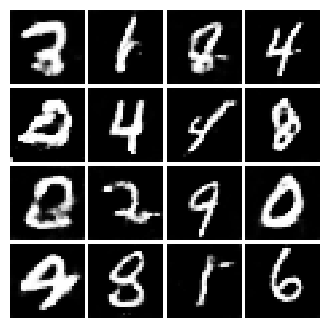

epoch: 1


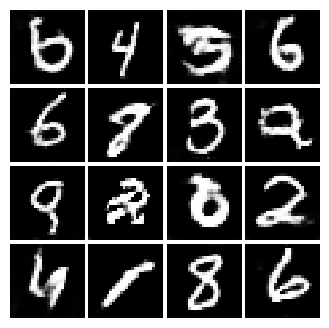

epoch: 2


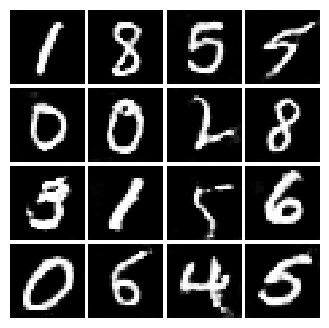

epoch: 3


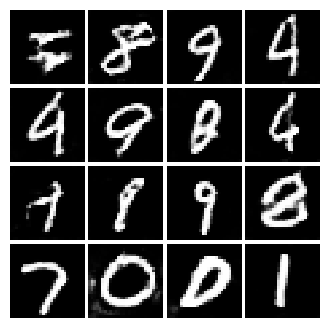

epoch: 4


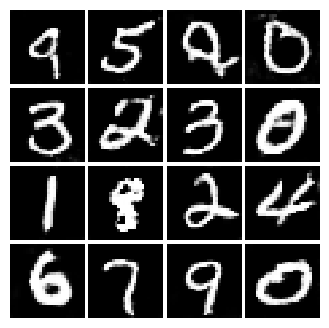

epoch: 5


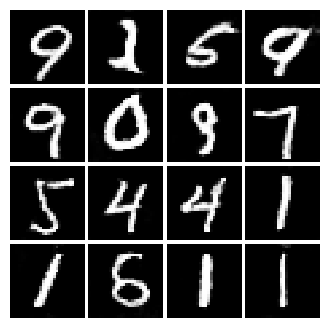

epoch: 6


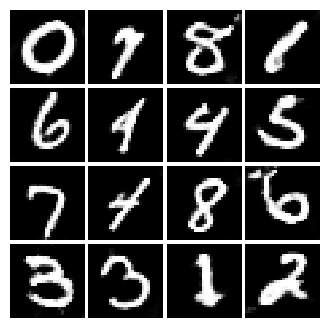

epoch: 7


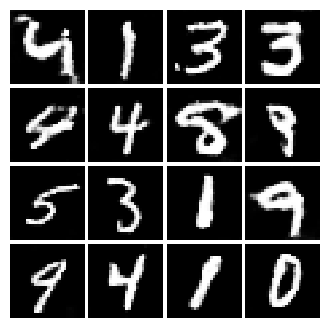

epoch: 8


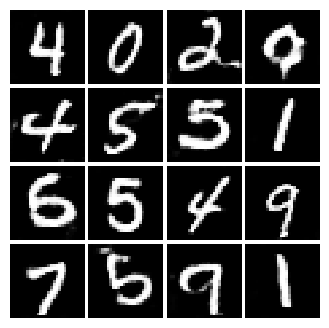

epoch: 9


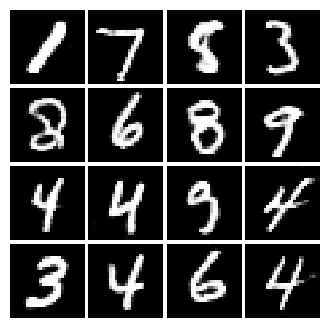

epoch: 10


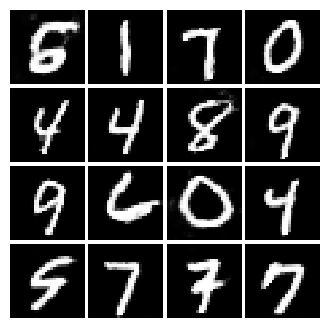

epoch: 11


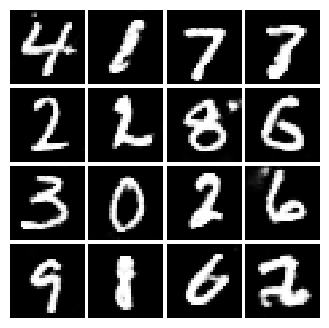

epoch: 12


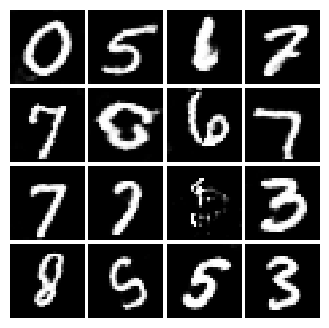

epoch: 13


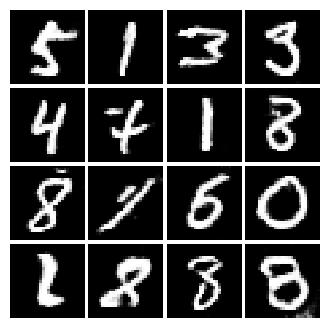

epoch: 14


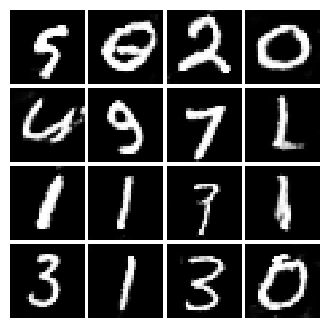

epoch: 15


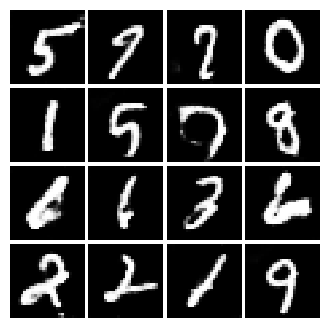

epoch: 16


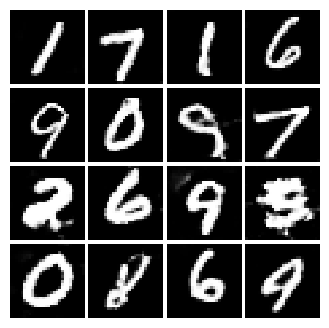

epoch: 17


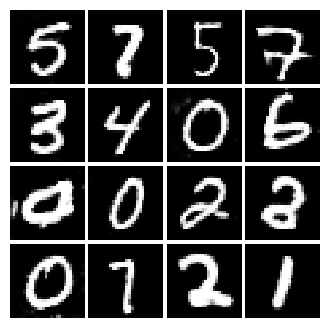

epoch: 18


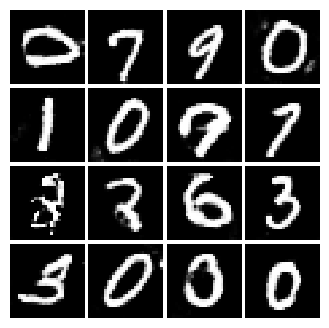

epoch: 19


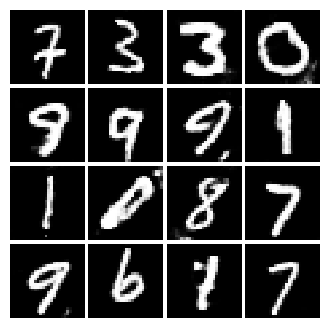

In [35]:
training()